# Word2Vec and LDA word cloud

Project: Naloxone NLP

Author: Jackson Reimer

Last Update: June 16th, 2019

Function: This script inputs reddit data from csv's, formats them into lists and processes them for Latent Dirichlet Allocation and Word2Vec. This script outputs two primary sets of word clouds for both naloxone and non-naloxone related conversations and five primary word associations for Word2Vec exploration

# Set up
## I. Import Packages

In [1]:
import csv
import re
import os
import nltk
import argparse
import itertools
import glob
import datetime
import gensim
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np
import matplotlib as plt
from collections import Counter, defaultdict, deque, OrderedDict
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
import nltk
from itertools import chain
from gensim import corpora, models
from gensim.models import LsiModel
from gensim.models import Word2Vec
import sys
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
sys.path.insert(0, '/Users/jackiereimer/Dropbox/Drug Pricing Project/code/reddit_preprocessing')
from reddit_preprocessing import reddit_preprocessing as rp
np.random.seed(2018)
nltk.download('wordnet')
pd.options.display.max_colwidth = 900
porter_stemmer = PorterStemmer()
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jackiereimer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## II. Set up default folder locations 

In [2]:
class ArgumentContainer(object):
    def __init__(self):
        self.data_folder = "opiates"
        self.keyterm_folder = "keyterm_lists"
        self.complete_threads_file = "use_data/threads/all_dumps.csv"
        self.complete_comments_file = "use_data/comments/all_comments.csv"
        self.stop_words = "stop_words"
        self.location_folder = "location"
        self.meth_folder = "methadone"
        self.sub_folder = "suboxone"
        self.nalt_folder = "naltrexone"
        self.narc_folder = "naloxone"
        self.mat_folder = "mat"
        self.unit_folder = "unit"
        self.currency_folder = "currency"
        self.output_folder = "output"
        self.file_folder = None


if 'args' not in dir():
    args = ArgumentContainer()


## III. Define Functions
    a. Input dataframe and define a subset with a keyword regex
    b. Input a list of strings and output the list tokenized at the word level
    c. Remove stop words from a list of tokeinzed strings
    d. Replace synonyms with common phrase within list of tokenized strings
    e. Stem words within a list of tokenized strings
    f. create a dictionary from a list

In [3]:
def convert_key_word_threads_to_df(df, search_for, regexp, case_sensitive=False):
    """
    """
    print('Number of strings searched: %s' % df.shape[0])
    print('Number of keywords searching for: %s' % len(search_for))
    dt_start = datetime.datetime.now()
    print('Starting time:', dt_start)
    if not case_sensitive:
        flag = re.I
    else:
        flag = False
    i = 0
    for keyword in search_for:
        i += 1
        print('Word %s out of %s' % (i, len(search_for)))
        print('Time elapsed:', datetime.datetime.now() - dt_start)
        word = re.compile(regexp.format(keyword), flags=flag)
        df[keyword] = df.astype(str).sum(axis=1).str.contains(word, regex=True)
    return df

def tokenize_list_of_strings(list_of_strings):
    list_of_tokenized_strings = []
    i = 1
    for string in list_of_strings:
#        print(round(i/len(list_of_strings), 5))
        tokenized_string = word_tokenize(string)
        list_of_tokenized_strings.append(tokenized_string)
        i += 1
    return list_of_tokenized_strings

def remove_stops_from_tokenized_list_of_strings(list_of_tokenized_strings, stop_words):
    list_of_stopped_strings = []
    i = 1
    for string in list_of_tokenized_strings:
 #       print(round(i/len(list_of_tokenized_strings), 5))
        filtered_string = [w for w in string if not w in stop_words]
        list_of_stopped_strings.append(filtered_string)
        i += 1
    return list_of_stopped_strings

def standardized_keywords(list_of_tokenized_strings, keyword_list, replace_with='narcan'):
	list_of_vetted_strings = []
	i = 1
	for word in keyword_list:
		j = 1
		for string in list_of_tokenized_strings:
#			print("word %s: %s percent" % (i, round(j/len(list_of_tokenized_strings), 5)))
			filtered_string = [w.replace(word, replace_with) for w in string]
			list_of_vetted_strings.append(filtered_string)
			j += 1
		i += 1
	return list_of_vetted_strings

def stem_from_tokenized_list_of_strings(list_of_tokenized_strings):
    list_of_stemmed_strings = []
    i = 1
    for string in list_of_tokenized_strings:
#        print(round(i/len(list_of_tokenized_strings), 5))
        stemmed_string = [porter_stemmer.stem(word) for word in string]
        list_of_stemmed_strings.append(stemmed_string)
        i += 1
    return list_of_stemmed_strings

def create_dict(items):
        return dict(enumerate(items, 1))


## IV. Define keyword lists
*Functions Defined in Previous file titled reddit pre-processing*
    
    a. Get filepaths based off of those listed in II.
    b. Define non-case sensitive list of terms from Dropbox folder "keyword lists"
    
**NOTE 5/4:**

When multiple lists are being generated at once, the sequence in which Python reads the csv's changes between sessions but is the same within each session. Double check that the list is being defined properly before proceeding by changing the sequence in which the lists are defined below.

In [4]:
locations_filepath, mat_filepath, all_comments_filepath, all_dumps_filepath, unit_filepath, currency_filepath, output_filepath, stopwords_filepath = rp.assign_location_dirs(args.data_folder, args.complete_threads_file, args.complete_comments_file, args.location_folder, args.mat_folder, args.unit_folder, args.currency_folder, args.output_folder, args.stop_words, args.file_folder)

All thread file: /Users/jackiereimer/Dropbox/drug_pricing_data/opiates/use_data/threads/all_dumps.csv
All comment file: /Users/jackiereimer/Dropbox/drug_pricing_data/opiates/use_data/comments/all_comments.csv
Stop Words file: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/stop_words
Locations file: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/location
MAT file: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/mat
Unit file: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/unit
Currency file: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/currency
Output folder: /Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/output


In [9]:
state_init, locations = rp.generates_non_case_sensitive_list_of_keyterms(locations_filepath)
narc_words, meth_words, nalt_words, sub_words = rp.generates_non_case_sensitive_list_of_keyterms(mat_filepath)
currencies = rp.generates_non_case_sensitive_list_of_keyterms(currency_filepath)[0]
units = rp.generates_non_case_sensitive_list_of_keyterms(unit_filepath)[0]
more_stops = rp.generates_non_case_sensitive_list_of_keyterms(stopwords_filepath)[0]

/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/location/locations.csv
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/location/state_init.csv
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/mat/naloxone_words.txt
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/mat/methadone_words.txt
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/mat/naltrexone_words.txt
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/mat/suboxone_words.txt
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/currency/currencies.csv
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/unit/quantity.csv
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/stop_words/stop_words.csv
/Users/jackiereimer/Dropbox/Drug Pricing Project/keyterm_lists/stop_words/stop_words.txt


    a. Combine all MAT related words
    b. Define Stopwords
    c. Import all threads and comment and combine them into a list of posts

In [8]:
narc_words

['evzio', 'naloxone', 'nrcn', 'nrcan', 'narcn', 'nar can', 'narcan']

In [10]:
mat_words = narc_words + meth_words + sub_words + nalt_words
stop = stopwords.words('english')
stop_all = stop + more_stops + ["'s", "'m", "'d", '...', ',', '.', '?', '!', '-', ':', "'ve", "'re", "''", "'"]

total_thread_tuples, total_threads = rp.list_of_threads_from_csv(args.data_folder, all_dumps_filepath)
total_comment_tuples, total_comments = rp.list_of_comments_from_csv(args.data_folder, all_comments_filepath)
total_posts = total_threads + total_comments

All r/opiates/ threads aggregated
All r/opiates/ comments aggregated


    a. Define headers of features for data frames to be generated
    b. Create comments, threads data frames and append the former to the latter
    c. Convert all posts to lower case
    d. Drop duplicates in sensitive features
    e. Change missing text fields with empty text 
    f. Append post body and post title

In [11]:
thread_tuples_headers = ['post_id','time','no_comments', 'post_title', 'post_body']
comment_tuples_headers = ['comment_id', 'time', 'reply_id', 'post_body']

comment_df = pd.DataFrame(total_comment_tuples, columns=comment_tuples_headers)
thread_df = pd.DataFrame(total_thread_tuples, columns=thread_tuples_headers)
reddit_df = thread_df.append(comment_df)
reddit_df = reddit_df[['time', 'post_id', 'reply_id', 'no_comments', 'comment_id', 'post_title', 'post_body']]

reddit_df = reddit_df.applymap(lambda s:s.lower() if type(s) == str else s)

reddit_df = reddit_df.drop_duplicates(subset=['post_id', 'comment_id', 'post_title', 'post_body'])

reddit_df.post_title = reddit_df.post_title.fillna('')

reddit_df['full_post'] = reddit_df['post_body'] + " " + reddit_df['post_title']

/anaconda/envs/snorkel/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Define regular d:

    a. Matches standalone strings
    b. Matches Numbers one and three digits in length
    c. Matches standalone numbers of currency format with preceding currency symbol
    d. Matches string of format 'digit(s)/letter(s)'
    e. Matches the five words that surround the mention of a dollar sign
    f. Requires three inputs (digit, keywords, digit), matches the digit number of words that surround keyword

In [12]:
general_re = r"^.*\b({})\b.*$"
digit_re = r"\s\b\d{1,3}\b"
price_re = r'^.*[{}]\s?\d{{1,3}}(?:[.,]\d{{3}})*(?:[.,]\d{{1,2}})?.*$'
unit_price_re = r'[{}]?\d+[/]\D\S+'
surrounding_dollar_re = r'(?P<before>(?:\w+\W+){5})\$\d+(?:\.\d+)?(?P<after>(?:\W+\w+){5})'
surrounding_words_re = r'(?P<before>(?:\w+\W+){})[{}]\d+(?:\.\d+)?(?P<after>(?:\W+\w+){})' 

Define Reddit as a dataframe with boolean features for each naloxone related keyword (Should take less than 10 minutes)

In [13]:
reddit_df = convert_key_word_threads_to_df(reddit_df, narc_words, general_re, case_sensitive=False)

Number of strings searched: 1976342
Number of keywords searching for: 7
Starting time: 2020-02-16 11:48:12.158698
Word 1 out of 7
Time elapsed: 0:00:00.000285


/anaconda/envs/snorkel/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


Word 2 out of 7
Time elapsed: 0:01:01.728702
Word 3 out of 7
Time elapsed: 0:02:51.166075
Word 4 out of 7
Time elapsed: 0:04:41.633360
Word 5 out of 7
Time elapsed: 0:06:13.540958
Word 6 out of 7
Time elapsed: 0:07:35.509518
Word 7 out of 7
Time elapsed: 0:09:16.633602


Define a subset of `reddit_df` with no naloxone related feature with a True value

In [14]:
narc_non_df = reddit_df.loc[(reddit_df['narcan'] != True) & (reddit_df['nrcn'] != True) & (reddit_df['narcn'] != True) & (reddit_df['evzio'] != True) & (reddit_df['naloxone'] != True) & (reddit_df['nar can'] != True) & (reddit_df['nrcan'] != True)]

Define a subset of `reddit_df` with at least one naloxone related feature with a True value

In [15]:
narc_only_df = reddit_df.loc[(reddit_df['narcan'] == True) | (reddit_df['nrcn'] == True) | (reddit_df['narcn'] == True) | (reddit_df['evzio'] == True) | (reddit_df['naloxone'] == True) | (reddit_df['nar can'] == True) | (reddit_df['nrcan'] == True)]

**Note:** At this point all steps must be duplicated for `narc_non_df` and `narc_only_df`.

Convert dataframe column for full post to list.

In [16]:
post_list = list(narc_only_df.full_post)

Tokenize each post in the list. After each post it outputs the percent of list that has been tokenized

In [17]:
post_list_tokenized = tokenize_list_of_strings(post_list)

Remove stop words from the list of tokenized posts. After each post it outputs the percent of list that has been processed.

In [18]:
post_list_no_stops = remove_stops_from_tokenized_list_of_strings(post_list_tokenized, stop_all)

**Optional:** Remove all occurences of the keyword in each tokenized post

In [19]:
post_list_no_keys = remove_stops_from_tokenized_list_of_strings(post_list_no_stops, narc_words)

Stem each post using NLTK's Porter Stemmer

In [20]:
post_stemmed = stem_from_tokenized_list_of_strings(post_list_no_stops)

The first line creates a dictionary of each of the stemmed lists of tokens

The second line removes words from the dictionary that occur fewer than 15 times, in less than 90 percent of the texts. It then keeps the top 10,000 (from approximately 11,500) 

In [21]:
dictionary = gensim.corpora.Dictionary(post_stemmed)
dictionary.filter_extremes(no_below=15, no_above=0.9, keep_n=100000)

For each item in the list of stemmed, tokenized posts, create a compressed document-term matrix in the form of a list. Each item in the list signifies a post and the subsequent items are the frequencies of the words in the post. It has to be a compressed matrix because otherwise it would be incredibly sparse and impossible to keep in the working memory. At this point, the Bag-of-Words comes into play and the sequence of the words in the post is lost.

In [22]:
bow_corpus = [dictionary.doc2bow(doc) for doc in post_stemmed]

Apply TF-IDF weighting to the BoW corpus

In [23]:
tfidf = models.TfidfModel(bow_corpus)

In [24]:
corpus_tfidf = tfidf[bow_corpus]

Apply LDA model to TF-IDF DTM. `num_topics=8` for `narc_non_df` and `num_topics=7` for `narc_only_df`

In [25]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=8, id2word=dictionary, passes=2, workers=2)

This nexxt function is to generate the most distinctive post of each topic:

Create an empty dataframe
for each topic in the model
for each of the sorted rows in the 

In [26]:
for i, row_list in enumerate(lda_model_tfidf[corpus_tfidf]):
        row = row_list[0] if lda_model_tfidf.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        print(row)

[(1, 0.7920314), (0, 0.029723942), (7, 0.029720636), (2, 0.02971568), (5, 0.029710703), (3, 0.0297008), (6, 0.029700594), (4, 0.029696263)]
[(0, 0.59901583), (4, 0.23453993), (5, 0.027746405), (1, 0.02774453), (7, 0.027743166), (3, 0.027741421), (2, 0.027738502), (6, 0.027730208)]
[(1, 0.67568076), (2, 0.046355408), (0, 0.046333548), (7, 0.046331886), (5, 0.046330247), (6, 0.04632904), (3, 0.046319593), (4, 0.04631945)]
[(5, 0.6851503), (6, 0.045034826), (2, 0.044985697), (7, 0.044981796), (3, 0.04497686), (4, 0.044965975), (1, 0.044955496), (0, 0.044949014)]
[(4, 0.5700784), (0, 0.2110544), (5, 0.036502644), (2, 0.036496706), (7, 0.03649078), (6, 0.03647017), (1, 0.036455646), (3, 0.036451273)]
[(0, 0.71996915), (4, 0.040039897), (3, 0.040015496), (2, 0.040009536), (7, 0.03999329), (6, 0.039992888), (5, 0.03999108), (1, 0.039988667)]
[(7, 0.7737787), (4, 0.03235442), (3, 0.03234514), (5, 0.032342345), (6, 0.032323416), (0, 0.032296605), (1, 0.032284174), (2, 0.03227526)]
[(0, 0.593215

[(3, 0.6695877), (2, 0.24115834), (4, 0.014896271), (0, 0.014881806), (7, 0.014871052), (5, 0.014870131), (6, 0.014869089), (1, 0.014865637)]
[(3, 0.8404209), (4, 0.02281807), (1, 0.022799645), (5, 0.022797814), (0, 0.022792447), (6, 0.022791564), (7, 0.022790218), (2, 0.022789318)]
[(5, 0.57482404), (7, 0.3514159), (0, 0.0123118935), (6, 0.012305528), (3, 0.012292487), (4, 0.012287412), (1, 0.012285798), (2, 0.012276901)]
[(0, 0.7966541), (3, 0.029110393), (6, 0.029073901), (1, 0.029051187), (7, 0.029038237), (4, 0.029037798), (2, 0.02902928), (5, 0.029005086)]
[(0, 0.9070541), (4, 0.013297796), (7, 0.013285222), (5, 0.013284349), (3, 0.013282567), (1, 0.013268838), (2, 0.013264729), (6, 0.013262382)]
[(0, 0.86933655), (1, 0.01870327), (3, 0.018690849), (6, 0.018661182), (2, 0.018657988), (5, 0.018653704), (7, 0.018649241), (4, 0.018647185)]
[(3, 0.681763), (1, 0.045509033), (4, 0.045473285), (2, 0.04546931), (0, 0.045464374), (6, 0.045443412), (7, 0.045441557), (5, 0.045436062)]
[(0,

[(1, 0.8449081), (7, 0.022397902), (2, 0.022163771), (3, 0.022137793), (4, 0.022102918), (6, 0.022102866), (0, 0.022100238), (5, 0.022086374)]
[(3, 0.87483704), (4, 0.017893368), (5, 0.01789098), (0, 0.01788115), (7, 0.017875953), (1, 0.017875332), (6, 0.017874535), (2, 0.017871682)]
[(3, 0.8800567), (0, 0.017156456), (2, 0.017149186), (5, 0.017141726), (6, 0.017134944), (4, 0.017123027), (7, 0.017120209), (1, 0.017117819)]
[(3, 0.755267), (2, 0.034995414), (6, 0.034976106), (0, 0.03497106), (5, 0.034952726), (7, 0.034947082), (1, 0.03494641), (4, 0.034944173)]
[(0, 0.7978687), (7, 0.02889404), (6, 0.028881133), (3, 0.028875014), (1, 0.0288733), (4, 0.028872376), (5, 0.028871454), (2, 0.028863989)]
[(6, 0.87349266), (3, 0.018214844), (0, 0.018177796), (1, 0.01805892), (2, 0.01803044), (5, 0.018015176), (4, 0.0180096), (7, 0.018000549)]
[(3, 0.8578627), (6, 0.020345945), (0, 0.020339359), (7, 0.02032994), (4, 0.020286497), (5, 0.020286478), (1, 0.020274809), (2, 0.020274235)]
[(6, 0.707

[(0, 0.5544673), (5, 0.3833338), (3, 0.010387304), (4, 0.010371261), (7, 0.010369402), (6, 0.010361189), (1, 0.010355412), (2, 0.0103542805)]
[(7, 0.8301766), (4, 0.024265755), (1, 0.024264904), (6, 0.02426272), (5, 0.024262216), (0, 0.024261508), (3, 0.024255516), (2, 0.024250755)]
[(3, 0.54078686), (4, 0.3008872), (0, 0.026396217), (1, 0.026393468), (2, 0.026386037), (7, 0.026384687), (5, 0.026384313), (6, 0.026381234)]
[(3, 0.8394679), (4, 0.023021344), (7, 0.022958798), (5, 0.022921849), (0, 0.022914024), (6, 0.022908948), (2, 0.022907682), (1, 0.02289951)]
[(6, 0.6824395), (1, 0.04540242), (0, 0.045401644), (4, 0.04537039), (5, 0.045360558), (3, 0.04535169), (2, 0.04533753), (7, 0.045336287)]
[(1, 0.64282316), (4, 0.05106318), (0, 0.051045556), (7, 0.051041003), (5, 0.051034715), (6, 0.051005095), (2, 0.050994188), (3, 0.05099307)]
[(0, 0.8805323), (5, 0.017071564), (4, 0.017070545), (6, 0.017069466), (1, 0.017069103), (3, 0.017066266), (7, 0.017063987), (2, 0.017056746)]
[(2, 0.8

[(0, 0.89355844), (7, 0.015220533), (4, 0.015218728), (5, 0.015206929), (6, 0.015200979), (3, 0.0151994955), (2, 0.015198365), (1, 0.015196513)]
[(1, 0.66666764), (6, 0.2017893), (0, 0.022007376), (2, 0.021920519), (4, 0.02190589), (5, 0.021905165), (3, 0.021903798), (7, 0.021900294)]
[(0, 0.68526727), (4, 0.22408213), (6, 0.015123722), (1, 0.015109289), (3, 0.015108564), (2, 0.015106481), (5, 0.01510146), (7, 0.01510112)]
[(0, 0.5954578), (6, 0.057860058), (4, 0.057813693), (2, 0.057796262), (7, 0.0577857), (5, 0.057768647), (1, 0.05775984), (3, 0.057757977)]
[(2, 0.8644212), (7, 0.019381804), (3, 0.01937538), (4, 0.019371683), (0, 0.019370068), (6, 0.019369533), (1, 0.019356703), (5, 0.019353598)]
[(0, 0.70876235), (5, 0.04162907), (1, 0.041624773), (7, 0.041613188), (3, 0.041597396), (6, 0.04159183), (2, 0.04159071), (4, 0.0415907)]
[(2, 0.67247933), (3, 0.04680808), (1, 0.04679678), (0, 0.046795752), (6, 0.046793483), (5, 0.046790432), (7, 0.046775363), (4, 0.046760757)]
[(3, 0.805

[(6, 0.8448856), (0, 0.022169594), (5, 0.02216788), (1, 0.022167759), (2, 0.022164218), (4, 0.022155019), (3, 0.02214963), (7, 0.022140302)]
[(3, 0.42127764), (1, 0.39358282), (5, 0.030882029), (0, 0.030863266), (6, 0.03085668), (4, 0.03085473), (7, 0.030853268), (2, 0.030829575)]
[(1, 0.72430575), (0, 0.039412495), (3, 0.03939985), (7, 0.039388295), (4, 0.039377905), (6, 0.039375797), (5, 0.039372753), (2, 0.039367106)]
[(4, 0.7436674), (0, 0.03667431), (3, 0.036638174), (5, 0.036612812), (6, 0.03661127), (1, 0.036609367), (7, 0.036597062), (2, 0.036589567)]
[(6, 0.8158311), (5, 0.026339851), (7, 0.026314491), (2, 0.026313668), (0, 0.026308399), (4, 0.026302848), (1, 0.026300227), (3, 0.026289405)]
[(2, 0.82633245), (4, 0.0248438), (3, 0.024825165), (0, 0.024808051), (1, 0.02480412), (6, 0.024801007), (7, 0.02479813), (5, 0.024787292)]
[(3, 0.79700106), (6, 0.029028106), (0, 0.029006122), (4, 0.029004531), (5, 0.02899669), (7, 0.028994054), (2, 0.028985968), (1, 0.028983507)]
[(3, 0.8

[(5, 0.7492088), (6, 0.035853103), (3, 0.03584258), (4, 0.03583611), (7, 0.035831477), (1, 0.035813693), (2, 0.035808235), (0, 0.035806015)]
[(0, 0.8217191), (6, 0.025490753), (2, 0.025481256), (4, 0.025476156), (7, 0.025468035), (5, 0.025459087), (3, 0.02545603), (1, 0.02544959)]
[(7, 0.7584977), (6, 0.03451276), (0, 0.03451231), (1, 0.034502804), (2, 0.03450058), (3, 0.03449671), (5, 0.034490507), (4, 0.034486588)]
[(0, 0.6407435), (3, 0.051346447), (7, 0.051336825), (1, 0.051329367), (2, 0.051321995), (6, 0.0513141), (5, 0.051308855), (4, 0.051298965)]
[(1, 0.865635), (5, 0.019399976), (0, 0.019230282), (6, 0.019215742), (3, 0.019196806), (7, 0.01913805), (4, 0.019115701), (2, 0.019068483)]
[(3, 0.80608517), (5, 0.027726749), (4, 0.027725728), (6, 0.027722545), (0, 0.027720084), (7, 0.027691418), (1, 0.027665421), (2, 0.027662871)]
[(7, 0.8373032), (4, 0.02326482), (3, 0.023259314), (0, 0.02324562), (5, 0.02324251), (6, 0.023236958), (2, 0.023229795), (1, 0.023217754)]
[(6, 0.789239

[(2, 0.70920104), (5, 0.041607294), (0, 0.041560825), (7, 0.041540552), (6, 0.041540455), (1, 0.041525528), (4, 0.041518953), (3, 0.041505363)]
[(5, 0.8153201), (4, 0.026391154), (3, 0.026390748), (6, 0.026386335), (7, 0.026385855), (0, 0.026381653), (2, 0.026375271), (1, 0.026368923)]
[(2, 0.8416336), (0, 0.022692515), (1, 0.02263865), (3, 0.022619404), (5, 0.022613311), (6, 0.022604303), (4, 0.022600677), (7, 0.022597471)]
[(3, 0.8181705), (6, 0.025987647), (7, 0.025980758), (5, 0.025980622), (0, 0.025977902), (1, 0.025975948), (2, 0.025966814), (4, 0.025959803)]
[(0, 0.85626394), (5, 0.020542221), (1, 0.02053661), (6, 0.020535428), (2, 0.020534677), (3, 0.020532962), (7, 0.020527652), (4, 0.02052652)]
[(3, 0.8198861), (0, 0.02573544), (5, 0.025735063), (2, 0.025733933), (7, 0.02573352), (1, 0.025728991), (6, 0.02572642), (4, 0.025720563)]
[(4, 0.81547457), (3, 0.026370857), (0, 0.026367867), (2, 0.026361572), (5, 0.026361141), (1, 0.026354993), (6, 0.026354821), (7, 0.026354209)]
[(

[(3, 0.8223133), (7, 0.025440184), (4, 0.025395615), (6, 0.025394224), (0, 0.025375415), (1, 0.025363717), (5, 0.025361594), (2, 0.025355939)]
[(7, 0.7370411), (2, 0.03759485), (0, 0.037575863), (4, 0.037568852), (3, 0.037568793), (6, 0.037557933), (5, 0.037547417), (1, 0.037545137)]
[(5, 0.8408132), (1, 0.022756975), (7, 0.02274664), (4, 0.02274518), (3, 0.022736851), (0, 0.022735137), (6, 0.022733474), (2, 0.022732483)]
[(7, 0.5893917), (4, 0.058701668), (3, 0.058680616), (2, 0.05866177), (0, 0.058652773), (5, 0.058641884), (1, 0.058637816), (6, 0.058631804)]
[(0, 0.843108), (2, 0.02242524), (3, 0.022416027), (7, 0.02241392), (5, 0.022413783), (1, 0.022411838), (6, 0.022409897), (4, 0.022401333)]
[(1, 0.80773634), (4, 0.02747827), (3, 0.027475413), (0, 0.02747171), (5, 0.027468594), (7, 0.02745985), (6, 0.027455825), (2, 0.027454007)]
[(6, 0.77689856), (5, 0.031903055), (1, 0.031878036), (0, 0.031873483), (3, 0.03187238), (7, 0.031871133), (4, 0.03186611), (2, 0.031837214)]
[(1, 0.62

[(1, 0.5621174), (0, 0.0625862), (3, 0.06256424), (7, 0.06256403), (5, 0.06256253), (2, 0.06255168), (6, 0.06253393), (4, 0.06252005)]
[(7, 0.7313554), (6, 0.0383949), (0, 0.038387816), (3, 0.038385246), (5, 0.03837839), (1, 0.038371745), (4, 0.038369775), (2, 0.038356677)]
[(1, 0.7080793), (2, 0.041727394), (0, 0.041704938), (6, 0.04170247), (5, 0.04170197), (7, 0.041701302), (4, 0.041692816), (3, 0.041689888)]
[(4, 0.6373973), (7, 0.20022328), (1, 0.027088419), (2, 0.02706656), (6, 0.02706535), (3, 0.027056487), (5, 0.027053474), (0, 0.027049195)]
[(7, 0.8067021), (6, 0.02775392), (2, 0.027617682), (4, 0.027596349), (3, 0.027583856), (1, 0.027583774), (5, 0.027582435), (0, 0.027579857)]
[(4, 0.79468286), (5, 0.029348241), (2, 0.029342059), (0, 0.02933225), (6, 0.029324844), (3, 0.029323965), (7, 0.029323816), (1, 0.029322015)]
[(5, 0.80540097), (2, 0.02792649), (0, 0.027883569), (3, 0.027788967), (7, 0.027758654), (4, 0.027757568), (6, 0.02775534), (1, 0.027728517)]
[(3, 0.8227006), 

[(6, 0.5855098), (3, 0.33376315), (1, 0.013457654), (0, 0.013457507), (2, 0.013455287), (5, 0.013454694), (4, 0.013451031), (7, 0.0134509)]
[(1, 0.7593249), (4, 0.034405116), (3, 0.034389168), (7, 0.034382574), (6, 0.034382265), (5, 0.034376524), (0, 0.034369834), (2, 0.0343696)]
[(2, 0.7565921), (3, 0.034811962), (1, 0.034790166), (4, 0.03478136), (0, 0.03476553), (7, 0.034763146), (6, 0.034753162), (5, 0.034742586)]
[(6, 0.83823013), (0, 0.023132518), (3, 0.023119196), (7, 0.023108387), (2, 0.02310714), (1, 0.023103569), (5, 0.023099827), (4, 0.023099175)]
[(0, 0.8607765), (2, 0.019902326), (3, 0.01988972), (5, 0.019889688), (7, 0.019888943), (6, 0.019884989), (1, 0.019884098), (4, 0.01988372)]
[(6, 0.8001815), (2, 0.02855814), (7, 0.028556932), (5, 0.028549153), (0, 0.028542606), (3, 0.028541826), (1, 0.02853589), (4, 0.028533919)]
[(7, 0.7573291), (3, 0.034685098), (0, 0.03467494), (6, 0.034667827), (1, 0.034666594), (4, 0.034665845), (5, 0.034661498), (2, 0.034649085)]
[(0, 0.8203

[(5, 0.48091325), (0, 0.34151345), (6, 0.029618988), (7, 0.0296143), (3, 0.02960242), (1, 0.029593583), (4, 0.029572401), (2, 0.029571556)]
[(4, 0.77049524), (1, 0.033070832), (6, 0.032807637), (0, 0.0327499), (7, 0.03273823), (3, 0.032727268), (2, 0.03272165), (5, 0.03268923)]
[(1, 0.5842156), (2, 0.059429836), (0, 0.05940739), (4, 0.05940474), (6, 0.05939788), (5, 0.059397675), (3, 0.059374165), (7, 0.059372716)]
[(0, 0.79963213), (1, 0.028650096), (5, 0.02863106), (7, 0.028628958), (3, 0.028618218), (2, 0.028614806), (4, 0.028614037), (6, 0.02861071)]
[(0, 0.8219521), (1, 0.025499152), (3, 0.025438976), (2, 0.025437864), (5, 0.025431173), (6, 0.025424859), (7, 0.02540932), (4, 0.025406532)]
[(6, 0.48347616), (0, 0.39275002), (3, 0.02063652), (4, 0.020636473), (2, 0.020632012), (1, 0.020626131), (5, 0.02062542), (7, 0.020617228)]
[(5, 0.8299697), (1, 0.02430266), (3, 0.024295572), (7, 0.024288299), (2, 0.024287526), (6, 0.024286738), (0, 0.024286114), (4, 0.024283372)]
[(7, 0.5507836

[(1, 0.52309847), (0, 0.3474582), (4, 0.021582888), (7, 0.021579457), (3, 0.02157379), (6, 0.021572622), (5, 0.021568837), (2, 0.021565676)]
[(2, 0.81479806), (3, 0.02647603), (1, 0.026472325), (6, 0.026461354), (7, 0.026456589), (0, 0.026449816), (4, 0.026444525), (5, 0.02644132)]
[(7, 0.8586925), (3, 0.02019616), (5, 0.020189626), (0, 0.020188626), (2, 0.020185621), (4, 0.020183785), (1, 0.02018201), (6, 0.02018167)]
[(6, 0.7793775), (7, 0.03155894), (0, 0.031524293), (2, 0.031522177), (5, 0.03151486), (3, 0.031511623), (4, 0.03150236), (1, 0.031488247)]
[(2, 0.68593407), (5, 0.044872526), (1, 0.04487096), (7, 0.04486875), (0, 0.044867504), (6, 0.04486653), (3, 0.044859964), (4, 0.044859666)]
[(7, 0.5235583), (5, 0.34532645), (3, 0.02186093), (4, 0.021857431), (1, 0.021851886), (2, 0.021849984), (0, 0.021849953), (6, 0.021845091)]
[(4, 0.83708817), (5, 0.0232948), (0, 0.023278194), (3, 0.023274066), (2, 0.02327264), (1, 0.023270652), (7, 0.023263568), (6, 0.023257917)]
[(3, 0.8097306

[(3, 0.8125887), (0, 0.026875963), (2, 0.026777396), (4, 0.026763948), (6, 0.026757788), (7, 0.026748966), (5, 0.026747713), (1, 0.02673949)]
[(4, 0.76469636), (3, 0.033702068), (1, 0.03364021), (0, 0.03363669), (5, 0.03360427), (7, 0.033589642), (2, 0.03356726), (6, 0.03356348)]
[(5, 0.75597054), (3, 0.13136342), (0, 0.018785156), (1, 0.018784303), (2, 0.018783351), (7, 0.018772706), (6, 0.01877224), (4, 0.018768255)]
[(4, 0.8654026), (5, 0.019268192), (6, 0.019231962), (3, 0.019223072), (0, 0.019222952), (7, 0.019222077), (1, 0.019219045), (2, 0.0192101)]
[(6, 0.60853535), (1, 0.25907204), (2, 0.02207996), (0, 0.022072539), (5, 0.02206674), (3, 0.02205979), (7, 0.022056941), (4, 0.022056594)]
[(2, 0.83433306), (4, 0.023730675), (3, 0.02367587), (7, 0.023673812), (6, 0.023663757), (5, 0.023649886), (1, 0.023637148), (0, 0.02363575)]
[(1, 0.7160496), (0, 0.040602982), (3, 0.040578626), (6, 0.04056877), (7, 0.040552963), (5, 0.040550783), (2, 0.040550306), (4, 0.040545966)]
[(6, 0.59641

[(1, 0.41444036), (3, 0.3838849), (0, 0.03362468), (7, 0.033615403), (6, 0.033615384), (5, 0.033609647), (4, 0.033608716), (2, 0.033600904)]
[(7, 0.861891), (0, 0.019743303), (1, 0.019733557), (4, 0.019732762), (3, 0.019732166), (6, 0.019726096), (5, 0.01972606), (2, 0.019715024)]
[(7, 0.56182563), (1, 0.06261543), (6, 0.062608086), (3, 0.06260498), (4, 0.062589556), (2, 0.06258792), (5, 0.0625874), (0, 0.062580965)]
[(4, 0.8186976), (0, 0.02592154), (3, 0.02590795), (2, 0.025900612), (7, 0.025898287), (1, 0.02589397), (6, 0.02589233), (5, 0.025887692)]
[(1, 0.66175973), (2, 0.048359577), (7, 0.048320003), (5, 0.04831544), (6, 0.04831367), (3, 0.04831245), (0, 0.048309967), (4, 0.04830917)]
[(7, 0.838308), (3, 0.023116397), (2, 0.023113184), (5, 0.023103213), (1, 0.023101429), (0, 0.02309167), (6, 0.023087451), (4, 0.023078633)]
[(0, 0.8156364), (4, 0.026348097), (5, 0.026346233), (6, 0.02634475), (2, 0.026337309), (7, 0.02633648), (1, 0.026328165), (3, 0.026322538)]
[(0, 0.77027285), 

[(3, 0.78617334), (0, 0.030580945), (7, 0.030557841), (5, 0.030547261), (2, 0.030539174), (4, 0.030535394), (1, 0.030533308), (6, 0.030532701)]
[(4, 0.8043313), (7, 0.027997708), (1, 0.02798067), (3, 0.027959729), (0, 0.027951779), (5, 0.027935604), (2, 0.027925426), (6, 0.027917799)]
[(2, 0.76187843), (6, 0.03411488), (4, 0.03406019), (0, 0.03404643), (1, 0.034007), (3, 0.033974312), (7, 0.033960987), (5, 0.03395777)]
[(6, 0.7740066), (3, 0.032319993), (7, 0.032316998), (5, 0.032286655), (0, 0.03227711), (1, 0.032269746), (4, 0.03226893), (2, 0.03225397)]
[(3, 0.79438096), (2, 0.029400637), (4, 0.029388094), (5, 0.02938486), (6, 0.029372444), (0, 0.029365819), (7, 0.029356787), (1, 0.02935041)]
[(1, 0.5953055), (3, 0.31927156), (7, 0.014242573), (2, 0.014238223), (5, 0.014236124), (4, 0.014235905), (0, 0.014235237), (6, 0.014234895)]
[(0, 0.8635652), (5, 0.019510621), (2, 0.019490642), (3, 0.019489618), (7, 0.019488048), (4, 0.019487297), (1, 0.019486638), (6, 0.01948193)]
[(5, 0.8679

[(0, 0.8695144), (6, 0.018695062), (5, 0.01864285), (7, 0.018637115), (2, 0.018633878), (3, 0.01863046), (1, 0.018626811), (4, 0.018619439)]
[(6, 0.7458958), (5, 0.03630847), (7, 0.036304314), (0, 0.03630377), (4, 0.036302984), (2, 0.03629537), (1, 0.03629497), (3, 0.0362943)]
[(3, 0.8510152), (0, 0.021313095), (1, 0.021283248), (2, 0.021282505), (6, 0.021281214), (7, 0.021279495), (4, 0.021277007), (5, 0.0212682)]
[(2, 0.79181546), (1, 0.029764546), (6, 0.029744994), (7, 0.029740684), (5, 0.02973758), (4, 0.029736916), (0, 0.029736385), (3, 0.029723495)]
[(2, 0.65145946), (3, 0.20574173), (4, 0.023813762), (6, 0.023805838), (0, 0.023798589), (5, 0.023797318), (1, 0.02379167), (7, 0.023791596)]
[(1, 0.81679314), (6, 0.026178587), (5, 0.026178151), (3, 0.026176177), (0, 0.026173338), (7, 0.026169306), (4, 0.026166283), (2, 0.026165005)]
[(5, 0.45566928), (0, 0.41655815), (7, 0.021317802), (2, 0.021312527), (6, 0.02130925), (3, 0.021283926), (1, 0.021276783), (4, 0.021272242)]
[(0, 0.854

[(7, 0.7828261), (2, 0.031048076), (3, 0.031029347), (6, 0.031029219), (5, 0.031025087), (0, 0.03102047), (1, 0.031015905), (4, 0.031005831)]
[(5, 0.67864853), (3, 0.04592691), (7, 0.04592093), (6, 0.045912836), (2, 0.045906898), (0, 0.045902614), (1, 0.045897517), (4, 0.045883745)]
[(7, 0.811512), (1, 0.026937548), (6, 0.026935793), (2, 0.026935777), (3, 0.026926458), (5, 0.02692226), (0, 0.02691751), (4, 0.026912648)]
[(0, 0.73032516), (1, 0.038578957), (4, 0.038525525), (3, 0.038518503), (6, 0.038517423), (7, 0.038513914), (2, 0.03851084), (5, 0.038509652)]
[(3, 0.7270544), (7, 0.039027117), (4, 0.03900187), (1, 0.038992714), (0, 0.038987864), (6, 0.038985517), (2, 0.03897615), (5, 0.038974337)]
[(2, 0.47320628), (5, 0.37380052), (3, 0.025529265), (0, 0.025508206), (1, 0.025505805), (7, 0.025492575), (6, 0.025481524), (4, 0.025475869)]
[(6, 0.501555), (5, 0.34554023), (7, 0.025492894), (3, 0.02548959), (0, 0.025489135), (1, 0.0254836), (4, 0.025477841), (2, 0.025471695)]
[(6, 0.6804

[(5, 0.8403156), (7, 0.022821452), (4, 0.022820631), (0, 0.022819273), (3, 0.022818392), (1, 0.022806872), (2, 0.022800524), (6, 0.022797268)]
[(3, 0.8060835), (6, 0.027768899), (2, 0.027733656), (5, 0.027717773), (7, 0.027682962), (0, 0.02767994), (1, 0.027670672), (4, 0.027662646)]
[(5, 0.804199), (6, 0.07308024), (0, 0.020793367), (4, 0.020750783), (7, 0.02055771), (3, 0.02029414), (2, 0.020164203), (1, 0.020160591)]
[(3, 0.44725865), (7, 0.38735327), (1, 0.027602393), (0, 0.027565343), (2, 0.02756475), (6, 0.027561411), (4, 0.0275479), (5, 0.027546251)]
[(0, 0.6818985), (7, 0.045477383), (5, 0.04545026), (1, 0.0454462), (6, 0.045445085), (2, 0.045438156), (4, 0.045434132), (3, 0.045410343)]
[(0, 0.7170753), (3, 0.040435966), (7, 0.040430073), (5, 0.040427305), (2, 0.04040963), (1, 0.04040905), (6, 0.0404069), (4, 0.04040575)]
[(4, 0.81497145), (3, 0.026469199), (7, 0.02643874), (2, 0.026437275), (0, 0.026431011), (5, 0.026426855), (6, 0.026415575), (1, 0.02640985)]
[(6, 0.6185457),

[(0, 0.8067615), (3, 0.054592106), (2, 0.023124356), (7, 0.023110274), (5, 0.023107443), (6, 0.023103414), (1, 0.023101905), (4, 0.023098981)]
[(7, 0.82982856), (4, 0.024328845), (0, 0.02431649), (6, 0.024313245), (1, 0.024306564), (3, 0.024303954), (2, 0.024302838), (5, 0.02429954)]
[(3, 0.47827795), (0, 0.3843791), (6, 0.022899305), (4, 0.022897553), (1, 0.02289486), (7, 0.022888334), (2, 0.022881465), (5, 0.022881439)]
[(0, 0.8495954), (7, 0.021494936), (3, 0.021489816), (6, 0.021485804), (1, 0.02148553), (5, 0.021483269), (4, 0.02148261), (2, 0.021482594)]
[(7, 0.71954757), (4, 0.04007771), (3, 0.04007427), (2, 0.040069554), (0, 0.04006551), (1, 0.04006052), (6, 0.040058114), (5, 0.04004674)]
[(0, 0.57494617), (4, 0.27407977), (6, 0.025164796), (2, 0.025163785), (3, 0.025163785), (5, 0.025162868), (7, 0.025159676), (1, 0.025159186)]
[(1, 0.77756965), (6, 0.03180936), (0, 0.031790618), (7, 0.031788494), (4, 0.03177667), (5, 0.031767454), (2, 0.03174953), (3, 0.031748243)]
[(0, 0.812

[(3, 0.8342515), (0, 0.02369415), (4, 0.023687774), (6, 0.023679102), (5, 0.02367591), (1, 0.023675662), (7, 0.023671633), (2, 0.023664195)]
[(0, 0.8595241), (5, 0.02009303), (1, 0.020070553), (2, 0.020070396), (7, 0.020069206), (6, 0.02006036), (3, 0.020059824), (4, 0.020052532)]
[(6, 0.74089354), (3, 0.03705362), (7, 0.037023384), (5, 0.037017725), (2, 0.03701085), (4, 0.03700132), (0, 0.03700117), (1, 0.036998436)]
[(0, 0.7673024), (7, 0.0332493), (4, 0.033246025), (1, 0.033244923), (6, 0.03324254), (5, 0.03323896), (3, 0.03323886), (2, 0.03323699)]
[(1, 0.81284314), (3, 0.0267676), (7, 0.02673831), (6, 0.026737148), (0, 0.026735518), (5, 0.026727222), (4, 0.026725782), (2, 0.0267253)]
[(6, 0.7244007), (1, 0.039395463), (0, 0.03938427), (2, 0.039371777), (4, 0.039370235), (3, 0.039369076), (5, 0.039359905), (7, 0.039348546)]
[(5, 0.7686578), (1, 0.033060655), (4, 0.03305452), (3, 0.033049256), (2, 0.03304565), (6, 0.033045586), (7, 0.033043828), (0, 0.033042684)]
[(3, 0.44882765), (

[(2, 0.81975263), (5, 0.025783854), (1, 0.025756747), (6, 0.025749542), (0, 0.02574738), (4, 0.025739148), (7, 0.025738277), (3, 0.025732413)]
[(2, 0.71235794), (6, 0.041151393), (1, 0.041096985), (0, 0.041091915), (7, 0.041085318), (5, 0.041079976), (3, 0.0410762), (4, 0.041060254)]
[(2, 0.7866243), (5, 0.030515505), (1, 0.030494483), (3, 0.030492416), (6, 0.030479977), (0, 0.030468073), (7, 0.030464433), (4, 0.030460773)]
[(0, 0.8119229), (6, 0.026900116), (7, 0.026879212), (3, 0.026868215), (5, 0.02686784), (2, 0.026860373), (1, 0.026851742), (4, 0.02684962)]
[(7, 0.8120922), (4, 0.026861139), (0, 0.026857907), (3, 0.02684636), (6, 0.026843805), (5, 0.02684035), (2, 0.026836952), (1, 0.026821343)]
[(7, 0.79365575), (5, 0.029496817), (6, 0.029485516), (3, 0.029479146), (2, 0.029478408), (0, 0.029476268), (4, 0.029464304), (1, 0.02946375)]
[(1, 0.8347497), (0, 0.023624755), (3, 0.023618707), (2, 0.023614742), (6, 0.023601063), (4, 0.023600748), (7, 0.02359656), (5, 0.023593698)]
[(7, 

[(0, 0.8942274), (6, 0.01511704), (5, 0.015116043), (7, 0.015110376), (3, 0.015110369), (4, 0.015106674), (1, 0.015106578), (2, 0.015105599)]
[(0, 0.8400857), (6, 0.022858847), (2, 0.022854501), (7, 0.022845833), (3, 0.022842975), (5, 0.022840248), (1, 0.02283798), (4, 0.022833897)]
[(0, 0.8261847), (7, 0.024838584), (4, 0.02483533), (3, 0.024832847), (6, 0.024832832), (2, 0.024826469), (1, 0.02482493), (5, 0.024824366)]
[(0, 0.8418752), (3, 0.022598637), (7, 0.022591842), (2, 0.0225906), (1, 0.022586808), (5, 0.022586133), (6, 0.02258608), (4, 0.022584697)]
[(2, 0.8315238), (0, 0.024099313), (5, 0.02408325), (1, 0.024063306), (7, 0.024062175), (3, 0.024058782), (6, 0.024056066), (4, 0.024053348)]
[(5, 0.8837935), (3, 0.016611213), (7, 0.01660657), (4, 0.0166017), (0, 0.016600054), (2, 0.016598487), (6, 0.016596846), (1, 0.016591666)]
[(2, 0.7579558), (3, 0.034625508), (7, 0.034583643), (1, 0.034580685), (6, 0.034568764), (0, 0.034567825), (4, 0.034564715), (5, 0.03455311)]
[(0, 0.7834

[(7, 0.8913765), (0, 0.015521802), (2, 0.015519196), (3, 0.015519135), (6, 0.015517307), (5, 0.015515543), (1, 0.015515304), (4, 0.0155152045)]
[(3, 0.8441227), (6, 0.022293339), (4, 0.022274068), (7, 0.022267517), (1, 0.022264188), (5, 0.02226299), (0, 0.02226213), (2, 0.022253083)]
[(7, 0.72718424), (1, 0.039025422), (2, 0.038978275), (0, 0.038974665), (5, 0.038974527), (6, 0.038960345), (4, 0.038955554), (3, 0.03894694)]
[(5, 0.84641874), (0, 0.021965291), (3, 0.021945862), (4, 0.021939572), (2, 0.021936297), (1, 0.021935314), (6, 0.0219339), (7, 0.021925008)]
[(2, 0.79592353), (1, 0.029186174), (6, 0.02916626), (3, 0.029161073), (7, 0.029150741), (5, 0.029148428), (0, 0.029133951), (4, 0.029129783)]
[(1, 0.7686152), (7, 0.033065744), (5, 0.033061173), (2, 0.033060446), (3, 0.033060096), (0, 0.033050306), (4, 0.033045497), (6, 0.033041567)]
[(5, 0.84162104), (0, 0.022641053), (7, 0.022635322), (2, 0.022630023), (6, 0.022626584), (3, 0.02262299), (4, 0.022614857), (1, 0.022608109)]
[

[(7, 0.85557157), (1, 0.020643447), (4, 0.020639556), (3, 0.020639546), (5, 0.020630734), (0, 0.02062692), (2, 0.020626152), (6, 0.020622078)]
[(7, 0.8445424), (3, 0.022221409), (1, 0.022217957), (4, 0.022217099), (0, 0.022207083), (5, 0.0222034), (2, 0.022198288), (6, 0.022192417)]
[(6, 0.85229826), (2, 0.021112934), (4, 0.021106226), (7, 0.021101566), (3, 0.021097705), (0, 0.021095894), (1, 0.021094738), (5, 0.021092687)]
[(6, 0.7582743), (1, 0.034565464), (7, 0.034555674), (0, 0.034535784), (2, 0.034526836), (4, 0.034525633), (3, 0.034514684), (5, 0.03450165)]
[(1, 0.8249527), (7, 0.025017237), (0, 0.025008552), (5, 0.025006672), (4, 0.025006417), (6, 0.02500558), (3, 0.025003728), (2, 0.02499907)]
[(3, 0.70508206), (7, 0.042144686), (4, 0.04214025), (0, 0.042130537), (5, 0.042130515), (6, 0.042129286), (1, 0.042125165), (2, 0.04211751)]
[(2, 0.859258), (5, 0.020120362), (6, 0.020113762), (7, 0.020105548), (3, 0.020102412), (4, 0.020102335), (0, 0.02010139), (1, 0.020096213)]
[(6, 0

[(3, 0.8439376), (1, 0.022309657), (0, 0.022295915), (7, 0.022295505), (4, 0.022294942), (5, 0.02229175), (6, 0.022288134), (2, 0.022286516)]
[(7, 0.783539), (6, 0.030937532), (3, 0.030933144), (0, 0.030930266), (4, 0.030923553), (5, 0.030921346), (2, 0.030910002), (1, 0.030905122)]
[(7, 0.7616766), (5, 0.03405953), (0, 0.034056056), (3, 0.034054898), (4, 0.034044743), (2, 0.034038004), (1, 0.034036104), (6, 0.034034036)]
[(3, 0.8041651), (5, 0.027995013), (7, 0.027982999), (0, 0.027981749), (4, 0.027978595), (2, 0.02796783), (1, 0.027966348), (6, 0.027962351)]
[(7, 0.84816974), (1, 0.021715295), (3, 0.021705091), (5, 0.021690933), (2, 0.021681817), (0, 0.021680485), (6, 0.021679627), (4, 0.021676984)]
[(3, 0.7111547), (0, 0.04128934), (7, 0.041275147), (5, 0.04126882), (1, 0.04125857), (4, 0.041258395), (6, 0.04125455), (2, 0.041240424)]
[(5, 0.6283533), (7, 0.05312326), (0, 0.053100113), (4, 0.053095922), (3, 0.053085662), (1, 0.05308533), (6, 0.053079486), (2, 0.05307692)]
[(2, 0.78

[(2, 0.8248449), (1, 0.02503916), (3, 0.025024798), (6, 0.025022719), (4, 0.025020039), (5, 0.025019502), (0, 0.025018021), (7, 0.025010835)]
[(2, 0.81775784), (6, 0.026049731), (5, 0.026044717), (0, 0.026041102), (7, 0.026035838), (4, 0.026028283), (1, 0.02602413), (3, 0.026018359)]
[(2, 0.6441848), (6, 0.050866786), (0, 0.050859634), (7, 0.050840057), (5, 0.050835386), (4, 0.05080983), (3, 0.05080208), (1, 0.050801426)]
[(6, 0.8387274), (2, 0.023053594), (4, 0.023041995), (0, 0.02303923), (7, 0.023039166), (1, 0.02303389), (3, 0.023032935), (5, 0.023031784)]
[(7, 0.75152755), (2, 0.035508845), (5, 0.03550674), (1, 0.03549613), (3, 0.035493813), (4, 0.035490926), (0, 0.03548877), (6, 0.03548723)]
[(0, 0.7959818), (2, 0.029172888), (6, 0.029154357), (5, 0.029146118), (7, 0.02914329), (4, 0.029139321), (3, 0.029132724), (1, 0.029129457)]
[(7, 0.8190693), (4, 0.025857592), (1, 0.02585648), (3, 0.025852127), (6, 0.025851829), (0, 0.025843188), (5, 0.02583776), (2, 0.025831696)]
[(5, 0.680

[(3, 0.85497546), (1, 0.020726241), (0, 0.020725396), (2, 0.02072434), (7, 0.020717071), (5, 0.020712785), (6, 0.02070966), (4, 0.020709038)]
[(5, 0.80351794), (1, 0.028076518), (6, 0.028071938), (7, 0.028071199), (3, 0.02806972), (2, 0.028066859), (0, 0.02806648), (4, 0.028059328)]
[(4, 0.7353752), (7, 0.037834913), (3, 0.037818834), (2, 0.03780213), (5, 0.037800595), (6, 0.03779414), (0, 0.03778952), (1, 0.037784625)]
[(0, 0.7476461), (7, 0.036067653), (2, 0.036062926), (6, 0.036057416), (3, 0.036050107), (4, 0.03604761), (5, 0.036040124), (1, 0.036028106)]
[(7, 0.8234773), (6, 0.025244989), (0, 0.02522571), (1, 0.025220063), (2, 0.025216863), (3, 0.025210382), (4, 0.025202543), (5, 0.025202084)]
[(5, 0.8412774), (4, 0.022687633), (0, 0.022675222), (3, 0.022674734), (1, 0.022674251), (7, 0.02267225), (6, 0.022671053), (2, 0.022667442)]
[(6, 0.8602627), (1, 0.019966817), (0, 0.019965615), (4, 0.019964732), (7, 0.019964593), (2, 0.01995998), (5, 0.019958332), (3, 0.019957222)]
[(7, 0.7

[(7, 0.707662), (0, 0.17226018), (5, 0.020018863), (1, 0.02001821), (6, 0.020015452), (4, 0.02001196), (3, 0.020007767), (2, 0.020005608)]
[(3, 0.8850604), (1, 0.016424406), (2, 0.016424106), (7, 0.016420547), (0, 0.016420228), (6, 0.01641911), (5, 0.016415674), (4, 0.016415527)]
[(1, 0.781495), (6, 0.031234406), (3, 0.03122205), (4, 0.031220824), (0, 0.031213317), (2, 0.031208748), (7, 0.031206302), (5, 0.03119943)]
[(2, 0.8137362), (5, 0.026618157), (7, 0.026617369), (6, 0.02661287), (3, 0.02661034), (0, 0.026602445), (4, 0.02660224), (1, 0.02660039)]
[(1, 0.7641242), (0, 0.033719547), (4, 0.033716455), (6, 0.033713166), (7, 0.033700127), (5, 0.03369917), (3, 0.033672456), (2, 0.03365488)]
[(3, 0.7091455), (2, 0.041604005), (0, 0.041561194), (1, 0.041554138), (7, 0.041546896), (6, 0.041535683), (5, 0.041528534), (4, 0.04152408)]
[(1, 0.74910325), (2, 0.068585336), (0, 0.030404892), (6, 0.030400693), (5, 0.030388024), (4, 0.030375013), (7, 0.030374749), (3, 0.030368062)]
[(1, 0.821410

[(6, 0.48417792), (1, 0.420033), (3, 0.016039453), (0, 0.01596324), (2, 0.01596143), (4, 0.015944002), (5, 0.015943384), (7, 0.015937552)]
[(2, 0.830056), (6, 0.024293883), (0, 0.024286529), (7, 0.024277925), (4, 0.024275336), (1, 0.024273014), (3, 0.024270236), (5, 0.024267111)]
[(1, 0.8252963), (6, 0.024982277), (2, 0.02496451), (3, 0.024955653), (5, 0.02495491), (0, 0.024951791), (7, 0.02495068), (4, 0.02494392)]
[(7, 0.8029345), (5, 0.028177697), (2, 0.028153656), (1, 0.028150773), (6, 0.028149521), (3, 0.028147765), (0, 0.028143566), (4, 0.028142525)]
[(0, 0.8319214), (4, 0.02402231), (7, 0.024017483), (5, 0.024013583), (1, 0.024013245), (3, 0.02401142), (6, 0.024000583), (2, 0.023999939)]
[(0, 0.7976254), (4, 0.028943436), (5, 0.028917344), (2, 0.028914273), (6, 0.028904015), (7, 0.02890285), (1, 0.028901279), (3, 0.028891332)]
[(6, 0.8282497), (4, 0.024573453), (3, 0.024533503), (1, 0.024533488), (7, 0.024530893), (5, 0.024530506), (0, 0.024525823), (2, 0.024522584)]
[(0, 0.7433

In [27]:
def format_topics_sentences(ldamodel=None, corpus=corpus_tfidf, texts=post_stemmed):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # if this is the dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [28]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf, corpus=corpus_tfidf, texts=post_list)

In [29]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.7920,"narcan, get, peopl, needl, naloxon, exchang, send, free, would, like",anybody ever use this on someone od'ing when narcan wasn't readily available by itself? using buprenorphine to reverse opiate overdose.
1,1,0.0,0.5828,"naloxon, get, would, narcan, need, use, bupe, like, hit, suboxon",lost archives from my old profile was so high i forgot my password 🤣 only remember this night cause i had to narcan a someone who didn’t take my dope serious only takes a point hahah
2,2,1.0,0.6757,"narcan, get, peopl, needl, naloxon, exchang, send, free, would, like",and how much does it cost??? does narcan expire ??
3,3,5.0,0.6851,"’, naloxon, get, know, like, narcan, would, peopl, way, fuck",narcan parties are fake news
4,4,4.0,0.5703,"’, naloxon, narcan, like, use, would, time, fuck, got, shot",**targin 10mg oxy / 5mg naloxone** recreational value even with naloxone?
5,5,0.0,0.7200,"naloxon, get, would, narcan, need, use, bupe, like, hit, suboxon",ems department gives out 'buzz kill award' for most narcan use
6,6,4.0,0.4128,"’, naloxon, narcan, like, use, would, time, fuck, got, shot","will i get high off these? 10mg oxycodone and 5mg naloxone only ever taken panadeine forte, got some targin 10/5. what should i expect?"
7,7,0.0,0.5916,"naloxon, get, would, narcan, need, use, bupe, like, hit, suboxon","hey y'all , i see a lot of people talking about subox and how it doesn't get you high. it gets you high 100% , in jail each 8mg pill goes for 160$ canadian . depending on you opioid tolerance , iv seem the same guys over and over take as little as 2mg subox (snorted) and get so high there falling off there chair, and also puking there face off. then some just get high a bit. the longer your off any opioid and then do subox the higher you get , and if you do smaller amounts (1-4mg) you'll get higher then if you do larger amounts (8-16mg) cause there's narcan in subox (which acts as a blocker) so u can't overdose on it. also if your on any opioid and do subox together you'll instantly get sic. so if your on h or any opioid i wouldn't do subox until you actually at least 24 hours free of any opioid . yea so i'd say if your gonna do it , snort 1,2 mg to start i usually get the highest w..."
8,8,7.0,0.6158,"narcan, get, naloxon, od, suboxon, would, withdraw, back, peopl, time",get narcan
9,9,4.0,0.8679,"’, naloxon, narcan, like, use, would, time, fuck, got, shot","so my moms been drinking i think taking xanax and she just did about 10mg oxymorphone. i think she just started oding. she was nodding out for a bit than was snoring and she just kept like snoring in, almost like she wasn’t breathing and i yelled mom and she wasn’t responding and i ran over to her and started doing that sternum chest rub that i’ve seen cops do and she kinda woke up but just wasn’t there in the eyes and face. and i started yelling in her face get up than she like nodddded out again and so i kept doing the sternum thing and got her to stand. i took her upstairs and made her get into the shower to keep her awake from oding. is this okay? god i’m so scared. what should we do. we don’t have narcan help"


In [70]:
pd.options.display.max_colwidth = 15000

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9161,"free, get, needl, exchang, ’, narcan, would, know, use, naloxon","okay guys i havent posted here since i overdosed and like died and had to be revived, and haven't fucked with dope since, mostly since school started. i've been smoking weed and drinking but thats mostly it. i have been taking kpins and they really help with my anxiety but im so scared of the taper and withdrawal from them. i wanna talk to my sub doc about a script but dont wanna seem like a pill pusher. i just wanna let you guys know, that being sober isnt fucking any of the na bullshit they tell you. it's hard, it's painful, you cry a lot, you get overwhelmed, you can't supress your feelings with a needle in your arm. but at the end of the day, you know youre gonna wake up in the morning. no waking up sick, no turning belts inside out because of bite marks, no wearing long sleeves in the summer, no sitting in the car for what seems like an eternity when your guy is ""5 minutes away"" (you all know that bullshit) . it's not an easier life, or a less painful one, but it's a life. it's bills, it's shitty jobs, [insert rentons trainspotting quote here] but like he said. i chose life, and i'm not looking back. do i think about it ? every day. but i just don't pick up. that's the only solution. fuck na, fuck iop and therapists (well some are good if you can find one to connect with) fuck all the bullshit they tell you. for me, subs help a bunch and i wouldnt be where i am without them. i dont know what i wanted this post to be, but i just needed to get my feelings out and to the portion of the community that is my j fam. i love all of you and all your lives are worth it, whether you believe it or not. life is precious and to be covetted. i'm sorry for ranting, i candyflipped last night and maybe im just really emotional. i just really miss my dead friends. and i dont want to be the dead friend. i talk to his mom every day, and it breaks my heart. i could never do that to my mother which is mainly why i haven't gone back out there i guess. i'm a mess in general but lately more so. sorry for the rant. tl;dr life is precious, life is sacred, chose life, love your brothers and sisters, and let them know so. i'm sorry for the rant. i love all of you even though i dont know you. be safe, if you're in a otc narcan state, please buy it. please, everyone should have it and it saves lives. sorry for ranting. chose life, buy narcan, i love you guys and be safe. motivation and emotional ramblings"
1,1.0,0.8946,"naloxon, narcan, suboxon, bupe, get, subutex, affin, bind, pwd, peopl","hey guys, hope u are alright, so i am using like 200mg of morphine a day orally (yes, i know the ba isnt great), money is running low, so i am using methadone to save some money (1/4 of the morphine price), and it hold me for 24h, nothing more, nothing less, 40-50mg of methadone, 24h i start to feel wd, and i do my morphine, didnt feel the blocking effects already. i am fucked up with money, dont know more what to do, stop is almost impossible, and even i cant buy heroin, because here in brazil is almost non existent. i have a pharm contact that can get codeine, morphine, tramadol, oxycodone, buprenorphine (not suboxone, without naloxone - restiva brand name, transdermal), and today my contact told me he came across some duragesic patches (fentanyl transdermal). i am using normally 45mg of methadone everyday, and some days i skip my methadone dose and take morphine (less expensive), sometimes i can i buy oxy. i dont know more what to do, here in brazil, opiate addiction is like from another world, when i told the psysichiatrist about my addiction, i think i know more than he about that, couldn t give me any advice, i am lost, i really dont know what to do, i cant go through withdrawal. so i am thinking of the bupe patches, or the fentanyl patches, how can i use them? whats the deal on fentanyl? can i use them to help me in anywa

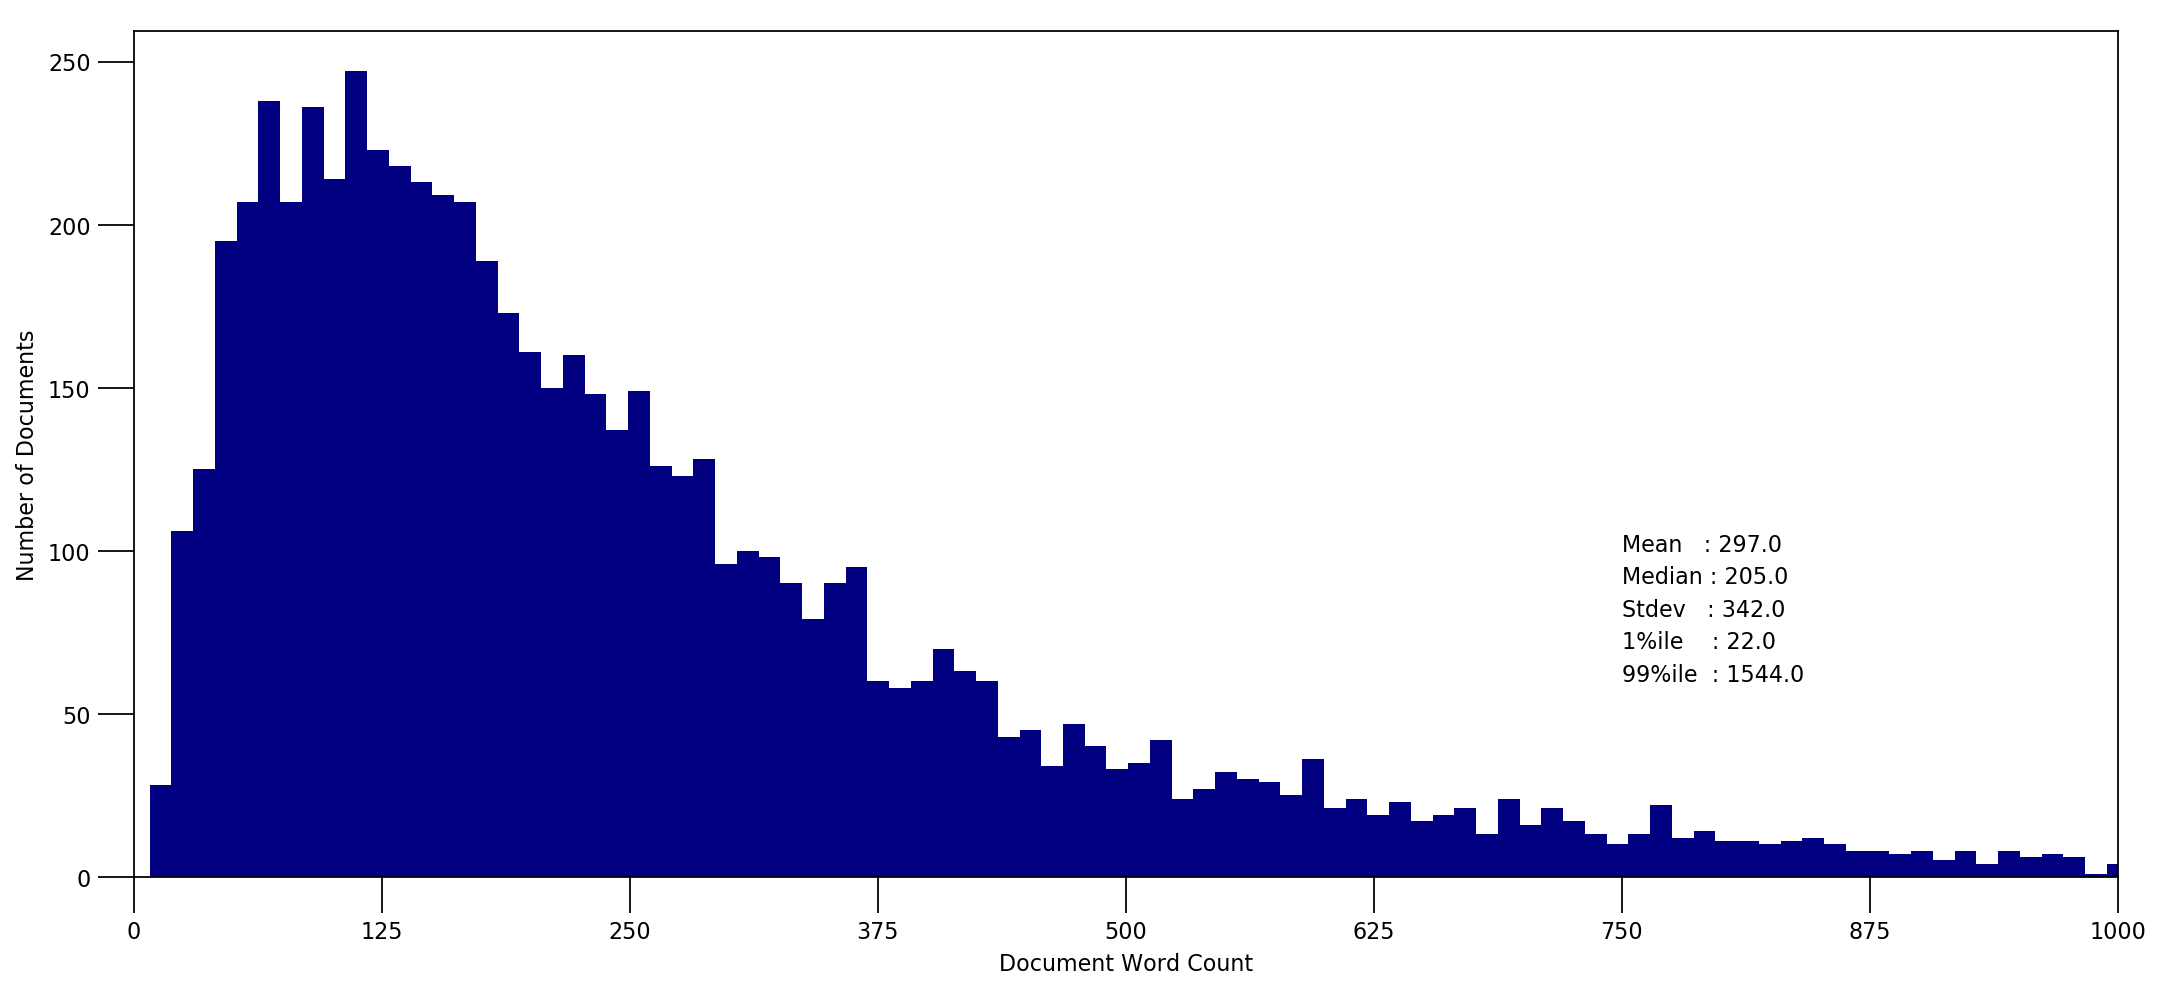

<Figure size 432x288 with 0 Axes>

In [30]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.show()
plt.savefig('lda_tfidf_gensim_narc_only_7_hist.png')

In [31]:
post_list = list(narc_non_df.full_post)
post_list_tokenized = tokenize_list_of_strings(post_list)
post_list_no_stops = remove_stops_from_tokenized_list_of_strings(post_list_tokenized, stop_all)
post_list_no_keys = remove_stops_from_tokenized_list_of_strings(post_list_no_stops, narc_words)
post_stemmed = stem_from_tokenized_list_of_strings(post_list_no_keys)

In [32]:
dictionary = gensim.corpora.Dictionary(post_stemmed)
dictionary.filter_extremes(no_below=15, no_above=0.9, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in post_stemmed]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [33]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=8, id2word=dictionary, passes=2, workers=2)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf, corpus=corpus_tfidf, texts=post_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf, corpus=corpus_tfidf, texts=post_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

In [80]:
pd.options.display.max_colwidth = 10000

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9086,"get, ’, time, shit, od, one, like, would, know, use","one example: waking up face down on the bathroom floor with a needle still in your arm, barely breathing, bodies freezing cold, pale, bluish skin tone, 5 or 6 hours have passed, covered in char, gear is all over the floor.. tried to stand up, but fell over immediately because my leg was completely numb from the amount of time i spent hunched over pinching the nerve in my back (had a dropfoot for almost 3 wks after that, was pretty scary). immediately started vomiting profusely. but really you don't feel it coming. it happens so quick, you don't realize what happened until its over. sometimes right after a shot you get the pins and needles feeling, and can tell right away you did too much (i know other ppl know what i'm talking about). this was with h, but any opiate od is gonna have the same effect, just maybe slower with pills depending on roa of course.. i suggest always having another person around, have narcan on hand, start with small doses etc etc.. ive oded a couple of times, and revived a few ppl.. crazy experiences, for sure.. stay safe out there.."
1,1.0,0.9202,"’, get, use, peopl, would, friend, go, carri, know, like","i recently had a very similar experience. but it was my 38 yr old nephew. i allowed him to live with me 3 months ago because he had been struggling with iv heroin and meth in another state, and basically screwing up his life. his parents (my sister and brother in law) won't let him live with them anymore. well i felt ok because he he got 9 months clean in a halfway house before coming here. and i want to help him. anyway, just last week i was in my room and heard a big boom from down the hall. i thought he knocked something over so i went to see. his door was closed and he wasn't answering. i went in and there he was dropped onto his back. the needle was right beside him, as was the spoon, etc. i was panicked. i have zero experience with od's , except what i have seen on tv. so i called 911. the responder kept me on the phone and made me do chest compressions. his breathing was very shallow and then would stop altogether for a minute. then he would start gasping and making terrible noises, but he never woke up. then he would stop breathing again, and we went through this cycle for about 10 minutes. finally the ambulance guys got there and gave him narcan. that brought him back. i was very grateful but also pissed and relieved and hurting for my nephew all at the same time. to the op, you have gotten excellent advice here. if your son needs another incentive tell him how wretched it is to be nearly middle aged and still broke, strung out, owning nothing of value and in and out of jail. because that's what happens to a lot of people who shoot drugs, or smoke crack or meth, or whatever. i didn't kick my 38 yr old nephew out... this time. but i told him that was the first and last time he will do that in my house. i don't know if he wants to be clean, but he does want a better life. maybe he'll decide to make the change."
2,2.0,0.8969,"need, would, get, use, someon, hand, know, http, like, one",yeah man you sound like every junkie i ever met and sound identical to me when i was younger. all i can say on it is i'm older now i got through it and looking back in glad i did. you want to die but you really don't you just don't want to deal with life anymore i can 100% relate. things will get better eventually just have faith but they may get worse before that. so just strap in man we only get one of these well maybe a couple if they narcan you in time but regardless no matter how bad you have it there are millions that would kill to be where your at just keep it in perspective. being young sucks being old sucks but being dead is the worst. hang in there if you ever need someone to talk to hit me up i'm always open for a chat seriously anytime. just take it slow if you feel like there's

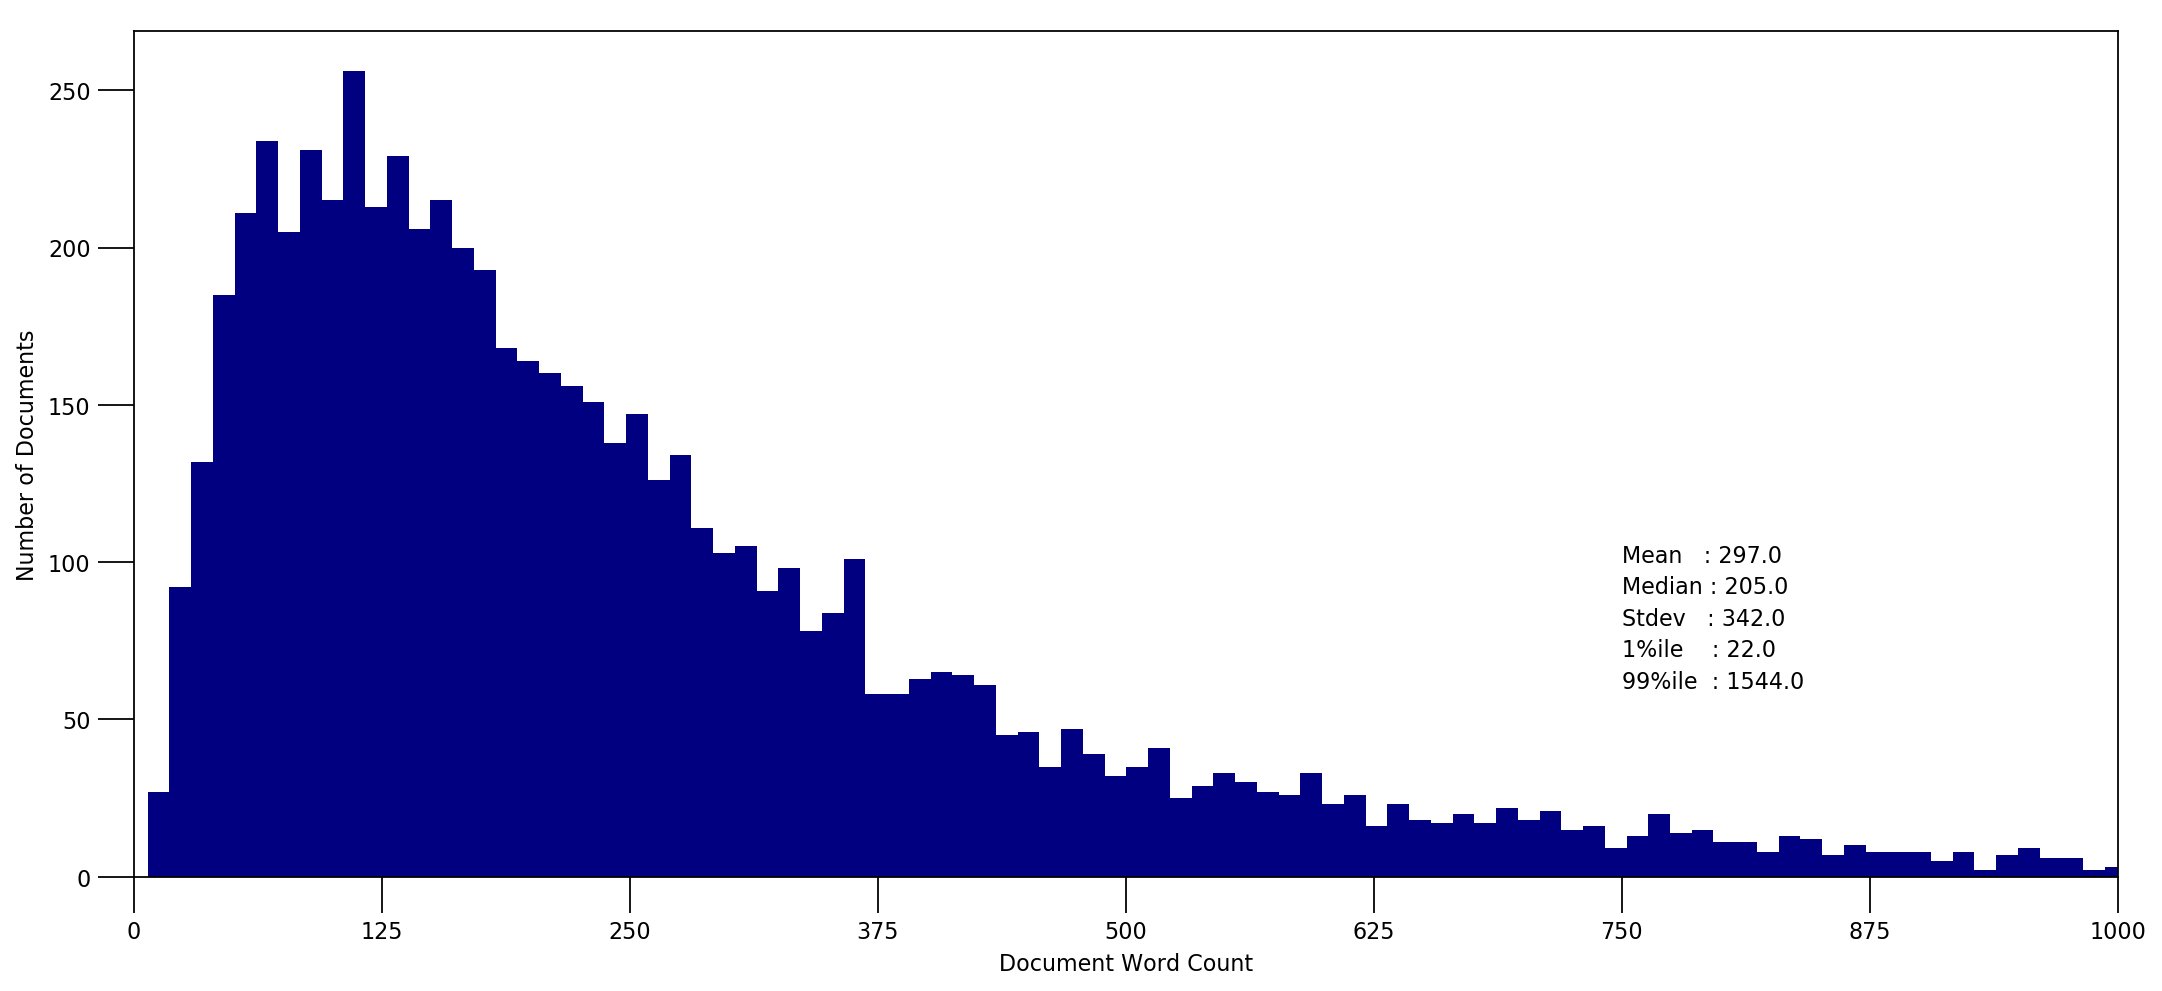

<Figure size 432x288 with 0 Axes>

In [81]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.show()
plt.savefig('lda_tfidf_gensim_narc_non_8_hist.png')

In [49]:
reddit_model = Word2Vec(post_stemmed, size=1000, window=5, min_count=1, workers=4)

# New Visualization

In [ ]:
n_topics = 20

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=n_topics, 
    random_state=100,
    update_every=1,
    chunksize=1000,
    passes=10,
    alpha='auto',
    per_word_topics=bTrue,
)

In [ ]:
lda_model.print_topics()

In [ ]:
topics = (
    pd.DataFrame(
        lda_model.show_topics(formatted=False, num_topics=n_topics)
    )
    .explode(1)
    .rename(columns={0: 'topic', 1: 'word'})
)
topics['value'] = topics.word.apply(lambda x: x[1])
topics['word'] = topics.word.apply(lambda x: x[0])
topics = topics.sort_values(['topic', 'value'], ascending=[1, 0])

In [ ]:
topics.to_csv('topics.csv')

In [ ]:
least_word = topics.reset_index().word.at[topics.reset_index().value.idxmin()]
text.apply(lambda x: least_word in x).sum(), least_word

In [ ]:
topics['rank'] = topics.groupby('topic').agg({'value': 'rank'}).add(-11).multiply(-1).astype(int)

In [ ]:
topics.pivot('topic', 'rank', 'word').reset_index().to_csv('topics_wide.csv', index=False)

## More

In [ ]:
lda_model.show_topics(num_topics=n_topics)

In [ ]:
document_topics = corpus.apply(lda_model.get_document_topics, minimum_probability=0).explode()
document_topics = pd.DataFrame({'topic': document_topics.apply(lambda x: x[0]), 'probability': document_topics.apply(lambda x: x[1])})
document_topics = document_topics.pivot(columns='topic', values='probability')

In [ ]:
document_topics.head()

In [ ]:
# this means we can just concat
(events.unique_id == flags.unique_id).all()

In [ ]:
topic_cols = document_topics.columns

In [ ]:
flag_cols = flags.columns.difference(['unique_id', 'key_case', 'month_yr'])

In [ ]:
full = pd.concat([document_topics, flags[flag_cols]], axis=1).corr().reindex(index=topic_cols, columns=flag_cols)

In [ ]:
fig, ax = plt.subplots(figsize=(21, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(full, ax=ax, cmap=cmap, vmin=-1, vmax=1)
ax.set_title('Correlation plot of topic probability with flag indicator')
ax.set_xlabel('flag')
ax.set_ylabel('topic')
fig.savefig('heatmap.png', dpi=200)